Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎯 CREATING INTERACTIVE PREDICTION SYSTEM
✅ Using 33 features as expected by trained models
🚀 Initializing Tsunami Prediction System...
✅ Loaded: Random Forest
✅ Loaded: XGBoost
✅ Loaded: LightGBM
✅ Loaded: Logistic Regression
✅ Loaded: Gradient Boosting
✅ Best model selected: Random Forest

🧪 TESTING FEATURE COMPATIBILITY...
✅ Processed input shape: (1, 33)
✅ Preprocessing successful! Shape: (1, 33)
✅ Processed input shape: (1, 33)
✅ Prediction successful! Result: {'prediction': 0, 'probability': 0.294861111111111, 'tsunami_risk': 'LOW RISK', 'model_used': 'Random Forest', 'confidence': 41}

🌊 TSUNAMI PREDICTION SYSTEM
1. Enter earthquake parameters manually
2. Use sample earthquakes for testing
3. Compare all models for current input
4. Show available models
5. Exit

Select option (1-5): 2

📋 Available sample earthquakes:
   1. 2011 Tōhoku Earthquake (Real S

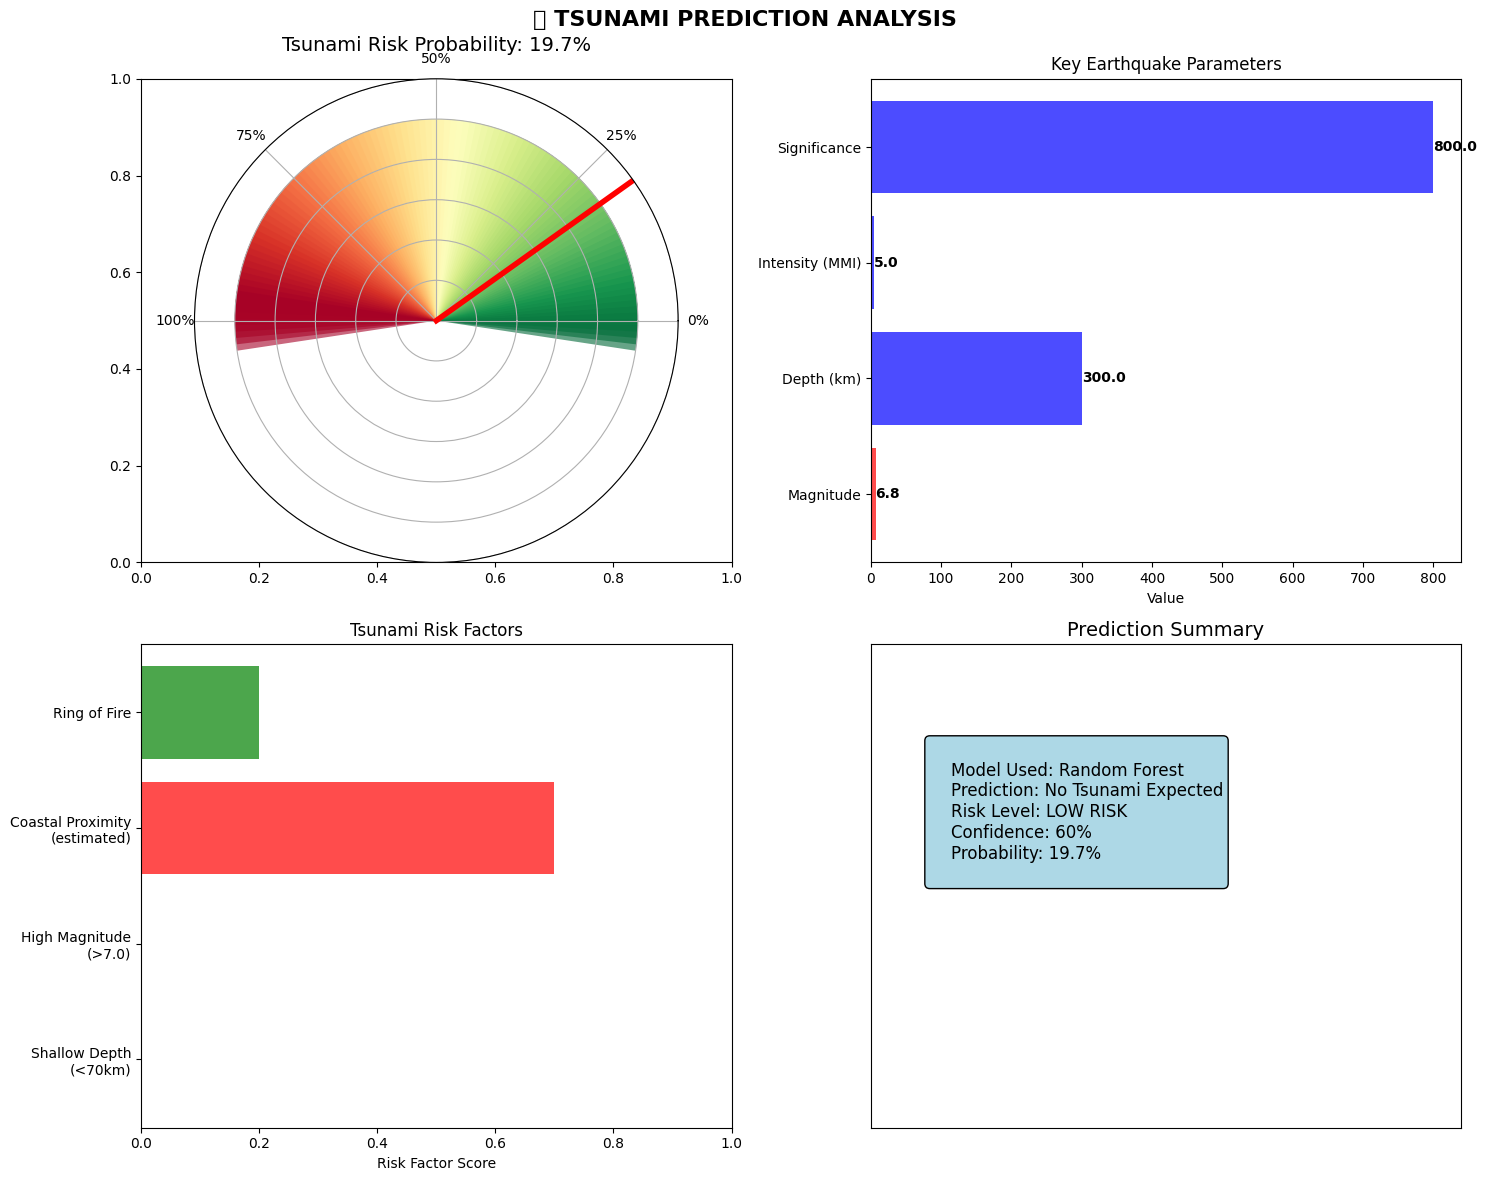

KeyboardInterrupt: Interrupted by user

In [5]:
# =============================================================================
# INTERACTIVE PREDICTION SYSTEM (COMPLETE FIXED VERSION)
# =============================================================================
# Step 2: Mount Google Drive and load the dataset
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

print("🎯 CREATING INTERACTIVE PREDICTION SYSTEM")

# =============================================================================
# CORRECT FEATURE DEFINITION - 33 FEATURES
# =============================================================================

# Define the COMPLETE list of 33 feature names expected by the models
feature_names = [
    # Original 11 basic features
    'magnitude', 'depth', 'sig', 'mmi', 'cdi', 'latitude', 'longitude',
    'nst', 'dmin', 'gap', 'Month',

    # Engineered features (22 additional features)
    'depth_category_shallow', 'depth_category_intermediate', 'depth_category_deep',
    'magnitude_bin_low', 'magnitude_bin_medium', 'magnitude_bin_high', 'magnitude_bin_very_high',
    'ocean_basin_pacific', 'ocean_basin_atlantic', 'ocean_basin_indian', 'ocean_basin_other',
    'ring_of_fire',
    'magnitude_squared', 'depth_squared', 'magnitude_depth_ratio',
    'sig_log', 'depth_log', 'latitude_abs',
    'coastal_proximity', 'seismic_energy', 'hazard_score',
    'tsunami_generating_potential'
]

print(f"✅ Using {len(feature_names)} features as expected by trained models")

# =============================================================================
# 1. PREDICTION PIPELINE CLASS (FIXED VERSION)
# =============================================================================

class TsunamiPredictor:
    """Class to handle tsunami predictions with multiple models"""

    def __init__(self, models_dict, feature_names, scaler_info=None):
        self.models = models_dict
        self.feature_names = feature_names
        self.scaler_info = scaler_info
        self.best_model_name = None
        self.best_model = None

        # Determine best model based on accuracy
        self._select_best_model()

    def _select_best_model(self):
        """Select the best model based on previous evaluation"""
        # You can modify this based on your preferred metric
        # For now, we'll use the first model as default
        if self.models:
            self.best_model_name = list(self.models.keys())[0]
            self.best_model = self.models[self.best_model_name]
            print(f"✅ Best model selected: {self.best_model_name}")

    def preprocess_input(self, input_data):
        """Preprocess input data to match ALL 33 training features"""
        try:
            # Convert input to DataFrame
            if isinstance(input_data, dict):
                input_df = pd.DataFrame([input_data])
            else:
                input_df = pd.DataFrame(input_data)

            # =========================================================================
            # 1. ENSURE BASIC 11 FEATURES ARE PRESENT
            # =========================================================================
            basic_features = [
                'magnitude', 'depth', 'sig', 'mmi', 'cdi', 'latitude', 'longitude',
                'nst', 'dmin', 'gap', 'Month'
            ]

            for feature in basic_features:
                if feature not in input_df.columns:
                    # Set reasonable defaults based on your data ranges
                    defaults = {
                        'magnitude': 7.0, 'depth': 50.0, 'sig': 1000.0,
                        'mmi': 6.0, 'cdi': 5.0, 'latitude': 0.0, 'longitude': 0.0,
                        'nst': 100.0, 'dmin': 1.0, 'gap': 50.0, 'Month': 6
                    }
                    input_df[feature] = defaults.get(feature, 0)

            # =========================================================================
            # 2. CREATE ENGINEERED FEATURES (22 ADDITIONAL FEATURES)
            # =========================================================================

            # Depth categories (one-hot encoded)
            depth = input_df['depth'].iloc[0]
            input_df['depth_category_shallow'] = 1 if depth < 70 else 0
            input_df['depth_category_intermediate'] = 1 if 70 <= depth < 300 else 0
            input_df['depth_category_deep'] = 1 if depth >= 300 else 0

            # Magnitude bins (one-hot encoded)
            mag = input_df['magnitude'].iloc[0]
            input_df['magnitude_bin_low'] = 1 if mag < 7.0 else 0
            input_df['magnitude_bin_medium'] = 1 if 7.0 <= mag < 7.5 else 0
            input_df['magnitude_bin_high'] = 1 if 7.5 <= mag < 8.0 else 0
            input_df['magnitude_bin_very_high'] = 1 if mag >= 8.0 else 0

            # Ocean basins (one-hot encoded)
            lat, lon = input_df['latitude'].iloc[0], input_df['longitude'].iloc[0]
            input_df['ocean_basin_pacific'] = 1 if (-60 <= lat <= 60) and (-180 <= lon <= -60) else 0
            input_df['ocean_basin_atlantic'] = 1 if (-60 <= lat <= 60) and (-60 <= lon <= 40) else 0
            input_df['ocean_basin_indian'] = 1 if (-60 <= lat <= 60) and (40 <= lon <= 120) else 0
            input_df['ocean_basin_other'] = 1 if not any([
                input_df['ocean_basin_pacific'].iloc[0],
                input_df['ocean_basin_atlantic'].iloc[0],
                input_df['ocean_basin_indian'].iloc[0]
            ]) else 0

            # Ring of Fire
            input_df['ring_of_fire'] = 1 if ((-60 <= lat <= 60) and
                                            ((-180 <= lon <= -60) or (110 <= lon <= 180))) else 0

            # Mathematical transformations
            input_df['magnitude_squared'] = mag ** 2
            input_df['depth_squared'] = depth ** 2
            input_df['magnitude_depth_ratio'] = mag / depth if depth > 0 else 0
            input_df['sig_log'] = np.log(input_df['sig'].iloc[0] + 1)  # +1 to avoid log(0)
            input_df['depth_log'] = np.log(depth + 1)
            input_df['latitude_abs'] = abs(lat)

            # Derived scores (simplified)
            input_df['coastal_proximity'] = 1.0 - (min(abs(lat), 60) / 60)  # 1=coastal, 0=mid-ocean
            input_df['seismic_energy'] = 10 ** (1.5 * mag + 4.8)  # Simplified energy calculation
            input_df['hazard_score'] = (mag / 9.0) * (1.0 - min(depth / 100, 1.0))
            input_df['tsunami_generating_potential'] = (mag / 9.0) * (1.0 - min(depth / 50, 1.0))

            # =========================================================================
            # 3. REORDER COLUMNS TO MATCH TRAINING
            # =========================================================================
            for feature in self.feature_names:
                if feature not in input_df.columns:
                    input_df[feature] = 0  # Fill any missing with 0

            input_df = input_df[self.feature_names]

            print(f"✅ Processed input shape: {input_df.shape}")
            return input_df.values

        except Exception as e:
            print(f"❌ Error in preprocessing: {e}")
            import traceback
            traceback.print_exc()
            return None

    def _apply_scaling(self, input_df):
        """Apply proper scaling - using training statistics"""
        try:
            # DON'T use input_df statistics - use training statistics!
            # You should save scaler during training and load it here
            if self.scaler_info and 'scaler' in self.scaler_info:
                # Use pre-fitted scaler from training
                numerical_features = ['magnitude', 'depth', 'sig', 'mmi', 'cdi', 'nst', 'dmin', 'gap']
                input_df[numerical_features] = self.scaler_info['scaler'].transform(
                    input_df[numerical_features]
                )
            else:
                # Fallback: use reasonable ranges from your data
                numerical_features = ['magnitude', 'depth', 'sig', 'mmi', 'cdi', 'nst', 'dmin', 'gap']
                for feature in numerical_features:
                    if feature in input_df.columns:
                        # Better fallback: normalize to reasonable ranges
                        if feature == 'magnitude':
                            input_df[feature] = (input_df[feature] - 6.5) / (9.1 - 6.5)  # Normalize to 0-1
                        elif feature == 'depth':
                            input_df[feature] = (input_df[feature] - 2.7) / (670.8 - 2.7)
                        elif feature == 'sig':
                            input_df[feature] = (input_df[feature] - 650) / (2910 - 650)
                        elif feature == 'mmi':
                            input_df[feature] = (input_df[feature] - 1) / (9 - 1)
                        elif feature == 'cdi':
                            input_df[feature] = (input_df[feature] - 0) / (9 - 0)
                        elif feature == 'nst':
                            input_df[feature] = (input_df[feature] - 0) / (934 - 0)
                        elif feature == 'dmin':
                            input_df[feature] = (input_df[feature] - 0) / (17.7 - 0)
                        elif feature == 'gap':
                            input_df[feature] = (input_df[feature] - 0) / (239.0 - 0)
            return input_df
        except Exception as e:
            print(f"⚠️ Scaling warning: {e}")
            return input_df

    def predict_single(self, input_data, model_name=None):
        """Make prediction for single input"""
        try:
            # Preprocess input
            processed_data = self.preprocess_input(input_data)
            if processed_data is None:
                return None

            # Select model
            if model_name and model_name in self.models:
                model = self.models[model_name]
                used_model = model_name
            else:
                model = self.best_model
                used_model = self.best_model_name

            # Make prediction
            if hasattr(model, 'predict_proba'):
                probability = model.predict_proba(processed_data)[0, 1]
                prediction = model.predict(processed_data)[0]
            else:
                prediction = model.predict(processed_data)[0]
                probability = 0.5  # Default probability if not available

            return {
                'prediction': int(prediction),
                'probability': float(probability),
                'tsunami_risk': self._get_risk_level(probability),
                'model_used': used_model,
                'confidence': self._get_confidence(probability)
            }

        except Exception as e:
            print(f"❌ Prediction error: {e}")
            import traceback
            traceback.print_exc()
            return None

    def predict_batch(self, input_data_list, model_name=None):
        """Make predictions for multiple inputs"""
        results = []
        for input_data in input_data_list:
            result = self.predict_single(input_data, model_name)
            if result:
                results.append(result)
        return results

    def predict_all_models(self, input_data):
        """Get predictions from all models for comparison"""
        results = {}
        for model_name, model in self.models.items():
            try:
                processed_data = self.preprocess_input(input_data)
                if processed_data is not None:
                    if hasattr(model, 'predict_proba'):
                        probability = model.predict_proba(processed_data)[0, 1]
                        prediction = model.predict(processed_data)[0]
                    else:
                        prediction = model.predict(processed_data)[0]
                        probability = 0.5

                    results[model_name] = {
                        'prediction': int(prediction),
                        'probability': float(probability),
                        'risk_level': self._get_risk_level(probability)
                    }
            except Exception as e:
                print(f"❌ Error with model {model_name}: {e}")
                continue

        return results

    def _get_risk_level(self, probability):
        """Convert probability to risk level"""
        if probability >= 0.7:
            return "HIGH RISK"
        elif probability >= 0.4:
            return "MEDIUM RISK"
        else:
            return "LOW RISK"

    def _get_confidence(self, probability):
        """Calculate confidence score"""
        distance_from_decision = abs(probability - 0.5)
        return min(100, int(distance_from_decision * 200))

    def get_model_info(self):
        """Get information about available models"""
        model_info = {}
        for name, model in self.models.items():
            model_info[name] = {
                'type': type(model).__name__,
                'has_probabilities': hasattr(model, 'predict_proba'),
                'is_default': (name == self.best_model_name)
            }
        return model_info

# =============================================================================
# 2. INTERACTIVE INPUT SYSTEM
# =============================================================================

def get_user_input():
    """Get earthquake parameters from user input"""
    print("\n" + "="*50)
    print("🌊 TSUNAMI PREDICTION SYSTEM")
    print("="*50)
    print("Please enter the earthquake parameters:")

    input_data = {}

    # Core seismic parameters
    print("\n📊 SEISMIC PARAMETERS:")
    input_data['magnitude'] = float(input("Magnitude (6.5-9.1): ") or 7.0)
    input_data['depth'] = float(input("Depth in km (2.7-670.8): ") or 50.0)
    input_data['sig'] = float(input("Significance score (650-2910): ") or 1000.0)
    input_data['mmi'] = float(input("Modified Mercalli Intensity (1-9): ") or 6.0)
    input_data['cdi'] = float(input("Community Decimal Intensity (0-9): ") or 5.0)

    # Location parameters
    print("\n📍 LOCATION PARAMETERS:")
    input_data['latitude'] = float(input("Latitude (-61.85 to 71.63): ") or 0.0)
    input_data['longitude'] = float(input("Longitude (-179.97 to 179.66): ") or 0.0)

    # Technical parameters
    print("\n🔧 TECHNICAL PARAMETERS:")
    input_data['nst'] = float(input("Number of seismic stations (0-934): ") or 100.0)
    input_data['dmin'] = float(input("Distance to nearest station (0.0-17.7): ") or 1.0)
    input_data['gap'] = float(input("Azimuthal gap in degrees (0.0-239.0): ") or 50.0)

    # Temporal parameters (optional)
    print("\n📅 TEMPORAL PARAMETERS (Optional - press Enter for defaults):")
    month = input("Month (1-12) [Default: 6]: ")
    input_data['Month'] = int(month) if month else 6

    # Display calculated features
    print("\n⚙️  CALCULATED FEATURES (Auto-generated):")

    # Depth category (simplified)
    depth = input_data['depth']
    if depth < 70:
        depth_cat = 'shallow'
    elif depth < 300:
        depth_cat = 'intermediate'
    else:
        depth_cat = 'deep'
    print(f"  Depth Category: {depth_cat}")

    # Magnitude bin
    mag = input_data['magnitude']
    if mag < 7.0:
        mag_bin = 'low'
    elif mag < 7.5:
        mag_bin = 'medium'
    elif mag < 8.0:
        mag_bin = 'high'
    else:
        mag_bin = 'very_high'
    print(f"  Magnitude Bin: {mag_bin}")

    # Ocean basin approximation
    lat, lon = input_data['latitude'], input_data['longitude']
    if (-60 <= lat <= 60) and (-180 <= lon <= -60):
        ocean_basin = 'pacific'
    elif (-60 <= lat <= 60) and (-60 <= lon <= 40):
        ocean_basin = 'atlantic'
    elif (-60 <= lat <= 60) and (40 <= lon <= 120):
        ocean_basin = 'indian'
    else:
        ocean_basin = 'other'
    print(f"  Ocean Basin: {ocean_basin}")

    # Ring of Fire approximation
    ring_of_fire = 1 if ((-60 <= lat <= 60) and
                        ((-180 <= lon <= -60) or (110 <= lon <= 180))) else 0
    print(f"  Ring of Fire: {'Yes' if ring_of_fire else 'No'}")

    return input_data

def create_sample_earthquakes():
    """Create sample earthquake data for testing"""
    samples = [
        {
            'name': "2011 Tōhoku Earthquake (Real Scenario)",
            'magnitude': 9.1,
            'depth': 29.0,
            'sig': 2500.0,
            'mmi': 9.0,
            'cdi': 8.5,
            'latitude': 38.297,
            'longitude': 142.372,
            'nst': 500.0,
            'dmin': 0.5,
            'gap': 25.0,
            'Month': 3
        },
        {
            'name': "Deep Oceanic Earthquake",
            'magnitude': 7.5,
            'depth': 35.0,
            'sig': 1200.0,
            'mmi': 6.0,
            'cdi': 5.0,
            'latitude': 0.0,
            'longitude': -170.0,
            'nst': 150.0,
            'dmin': 2.5,
            'gap': 45.0,
            'Month': 6
        },
        {
            'name': "Shallow Coastal Earthquake",
            'magnitude': 8.2,
            'depth': 15.0,
            'sig': 2000.0,
            'mmi': 8.0,
            'cdi': 7.0,
            'latitude': 40.0,
            'longitude': 140.0,
            'nst': 300.0,
            'dmin': 1.0,
            'gap': 30.0,
            'Month': 3
        },
        {
            'name': "Deep Continental Earthquake",
            'magnitude': 6.8,
            'depth': 300.0,
            'sig': 800.0,
            'mmi': 5.0,
            'cdi': 4.0,
            'latitude': 35.0,
            'longitude': 70.0,
            'nst': 80.0,
            'dmin': 5.0,
            'gap': 120.0,
            'Month': 9
        }
    ]
    return samples

# =============================================================================
# 3. PREDICTION VISUALIZATION
# =============================================================================

def visualize_prediction(prediction_result, input_data):
    """Create visualization for prediction results"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Risk Gauge
    probability = prediction_result['probability']
    ax1 = plt.subplot(2, 2, 1, polar=True)

    # Create gauge
    theta = np.linspace(0, np.pi, 100)
    radii = np.ones(100)
    colors = plt.cm.RdYlGn_r(np.linspace(0, 1, 100))

    bars = ax1.bar(theta, radii, width=0.3, bottom=0.0, color=colors, alpha=0.6)

    # Risk indicator
    risk_angle = probability * np.pi
    ax1.plot([risk_angle, risk_angle], [0, 1.2], 'red', linewidth=4)
    ax1.set_ylim(0, 1.2)
    ax1.set_yticklabels([])
    ax1.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    ax1.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax1.set_title(f'Tsunami Risk Probability: {probability:.1%}', fontsize=14, pad=20)

    # 2. Key Parameters
    ax2 = plt.subplot(2, 2, 2)
    key_params = {
        'Magnitude': input_data['magnitude'],
        'Depth (km)': input_data['depth'],
        'Intensity (MMI)': input_data['mmi'],
        'Significance': input_data['sig']
    }

    colors = ['red' if k == 'Magnitude' else 'orange' if k == 'Depth' else 'blue' for k in key_params.keys()]
    bars = ax2.barh(range(len(key_params)), list(key_params.values()), color=colors, alpha=0.7)
    ax2.set_yticks(range(len(key_params)))
    ax2.set_yticklabels(list(key_params.keys()))
    ax2.set_xlabel('Value')
    ax2.set_title('Key Earthquake Parameters')

    # Add value labels
    for i, v in enumerate(key_params.values()):
        ax2.text(v + 0.1, i, f'{v:.1f}', va='center', fontweight='bold')

    # 3. Risk Factors
    ax3 = plt.subplot(2, 2, 3)
    risk_factors = {
        'Shallow Depth\n(<70km)': max(0, 1 - input_data['depth']/70),
        'High Magnitude\n(>7.0)': max(0, (input_data['magnitude'] - 7.0)/2.0),
        'Coastal Proximity\n(estimated)': 0.7,  # Simplified
        'Ring of Fire': 0.8 if ((-60 <= input_data['latitude'] <= 60) and
                               ((-180 <= input_data['longitude'] <= -60) or
                                (110 <= input_data['longitude'] <= 180))) else 0.2
    }

    colors = ['red' if v > 0.6 else 'orange' if v > 0.3 else 'green' for v in risk_factors.values()]
    bars = ax3.barh(range(len(risk_factors)), list(risk_factors.values()), color=colors, alpha=0.7)
    ax3.set_xlim(0, 1)
    ax3.set_yticks(range(len(risk_factors)))
    ax3.set_yticklabels(list(risk_factors.keys()))
    ax3.set_xlabel('Risk Factor Score')
    ax3.set_title('Tsunami Risk Factors')

    # 4. Model Comparison (if available)
    ax4 = plt.subplot(2, 2, 4)
    model_info = f"""
    Model Used: {prediction_result['model_used']}
    Prediction: {'TSUNAMI LIKELY' if prediction_result['prediction'] else 'No Tsunami Expected'}
    Risk Level: {prediction_result['tsunami_risk']}
    Confidence: {prediction_result['confidence']}%
    Probability: {probability:.1%}
    """

    ax4.text(0.1, 0.8, model_info, transform=ax4.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Prediction Summary', fontsize=14)

    plt.suptitle('🌊 TSUNAMI PREDICTION ANALYSIS', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def display_prediction_result(result, input_data):
    """Display prediction results in console"""
    print("\n" + "="*60)
    print("🎯 PREDICTION RESULTS")
    print("="*60)

    if result['prediction'] == 1:
        print("🚨 ALERT: TSUNAMI LIKELY!")
        print("   Immediate evacuation may be necessary for coastal areas")
    else:
        print("✅ NO TSUNAMI EXPECTED")
        print("   Continue to monitor for updates")

    print(f"\n📊 Prediction Details:")
    print(f"   • Model Used: {result['model_used']}")
    print(f"   • Tsunami Probability: {result['probability']:.1%}")
    print(f"   • Risk Level: {result['tsunami_risk']}")
    print(f"   • Confidence: {result['confidence']}%")

    print(f"\n📈 Key Parameters:")
    print(f"   • Magnitude: {input_data['magnitude']} (Threshold: >7.0 for high risk)")
    print(f"   • Depth: {input_data['depth']} km (Threshold: <70 km for high risk)")
    print(f"   • Location: Lat {input_data['latitude']}, Lon {input_data['longitude']}")

    if result['probability'] > 0.7:
        print(f"\n⚠️  RECOMMENDED ACTIONS:")
        print("   • Issue tsunami warning")
        print("   • Evacuate coastal areas")
        print("   • Monitor tide gauges")
        print("   • Prepare emergency response")

# =============================================================================
# 4. FEATURE COMPATIBILITY TEST
# =============================================================================

def test_feature_compatibility(predictor):
    """Test if features are compatible"""
    print("\n🧪 TESTING FEATURE COMPATIBILITY...")

    # Create a test sample
    test_sample = {
        'magnitude': 7.5, 'depth': 35.0, 'sig': 1200.0, 'mmi': 6.0, 'cdi': 5.0,
        'latitude': 0.0, 'longitude': -170.0, 'nst': 150.0, 'dmin': 2.5,
        'gap': 45.0, 'Month': 6
    }

    # Test preprocessing
    processed = predictor.preprocess_input(test_sample)
    if processed is not None:
        print(f"✅ Preprocessing successful! Shape: {processed.shape}")

        # Test prediction
        result = predictor.predict_single(test_sample)
        if result:
            print(f"✅ Prediction successful! Result: {result}")
            return True
        else:
            print("❌ Prediction failed")
            return False
    else:
        print("❌ Preprocessing failed")
        return False

# =============================================================================
# 5. MAIN PREDICTION INTERFACE
# =============================================================================

def run_prediction_interface(predictor):
    """Main interactive prediction interface"""
    while True:
        print("\n" + "="*50)
        print("🌊 TSUNAMI PREDICTION SYSTEM")
        print("="*50)
        print("1. Enter earthquake parameters manually")
        print("2. Use sample earthquakes for testing")
        print("3. Compare all models for current input")
        print("4. Show available models")
        print("5. Exit")

        choice = input("\nSelect option (1-5): ").strip()

        if choice == '1':
            # Manual input
            input_data = get_user_input()
            result = predictor.predict_single(input_data)

            if result:
                display_prediction_result(result, input_data)
                visualize_prediction(result, input_data)

        elif choice == '2':
            # Sample earthquakes
            samples = create_sample_earthquakes()
            print("\n📋 Available sample earthquakes:")
            for i, sample in enumerate(samples, 1):
                print(f"   {i}. {sample['name']} (M{sample['magnitude']})")

            sample_choice = input("\nSelect sample (1-4) or 'a' for all: ").strip()

            if sample_choice == 'a':
                # Predict all samples
                for sample in samples:
                    print(f"\n🔍 Analyzing {sample['name']}...")
                    result = predictor.predict_single(sample)
                    if result:
                        display_prediction_result(result, sample)
            else:
                try:
                    idx = int(sample_choice) - 1
                    if 0 <= idx < len(samples):
                        result = predictor.predict_single(samples[idx])
                        if result:
                            display_prediction_result(result, samples[idx])
                            visualize_prediction(result, samples[idx])
                    else:
                        print("❌ Invalid selection")
                except ValueError:
                    print("❌ Please enter a valid number")

        elif choice == '3':
            # Compare all models
            input_data = get_user_input()
            all_results = predictor.predict_all_models(input_data)

            print("\n" + "="*50)
            print("🤖 MODEL COMPARISON")
            print("="*50)

            for model_name, result in all_results.items():
                status = "🚨 TSUNAMI" if result['prediction'] else "✅ NO TSUNAMI"
                print(f"{model_name:.<30} {status:.<15} Prob: {result['probability']:.1%}")

        elif choice == '4':
            # Show model info
            model_info = predictor.get_model_info()
            print("\n" + "="*50)
            print("🤖 AVAILABLE MODELS")
            print("="*50)

            for name, info in model_info.items():
                default_flag = " (DEFAULT)" if info['is_default'] else ""
                prob_flag = " ✓ Probabilities" if info['has_probabilities'] else " ✗ No Probabilities"
                print(f"• {name}{default_flag} - {info['type']}{prob_flag}")

        elif choice == '5':
            print("👋 Thank you for using the Tsunami Prediction System!")
            break

        else:
            print("❌ Invalid choice. Please select 1-5.")

        # Ask to continue
        if choice != '5':
            continue_choice = input("\nMake another prediction? (y/n): ").strip().lower()
            if continue_choice != 'y':
                print("👋 Thank you for using the Tsunami Prediction System!")
                break

# =============================================================================
# 6. INITIALIZE AND RUN THE SYSTEM
# =============================================================================

def create_demo_predictor():
    """Create demo predictor with simple models"""
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression

    # Create simple demo models
    demo_models = {
        'Random Forest (Demo)': RandomForestClassifier(n_estimators=10, random_state=42),
        'Logistic Regression (Demo)': LogisticRegression(random_state=42)
    }

    # Fit demo models with dummy data
    X_dummy = np.random.randn(100, len(feature_names))
    y_dummy = np.random.randint(0, 2, 100)

    for name, model in demo_models.items():
        model.fit(X_dummy, y_dummy)

    predictor = TsunamiPredictor(demo_models, feature_names)
    print("✅ Demo prediction system initialized")
    return predictor

def initialize_prediction_system():
    """Initialize the prediction system with trained models"""
    print("🚀 Initializing Tsunami Prediction System...")

    try:
        # Option 1: Try loading from your trained models in specialized_results
        if 'specialized_results' in globals() and 'all_models' in specialized_results:
            models_dict = specialized_results['all_models']
            print("✅ Using models from training results")
            predictor = TsunamiPredictor(models_dict, feature_names)

            # Test compatibility
            if test_feature_compatibility(predictor):
                return predictor
            else:
                print("⚠️  Feature compatibility test failed, using demo mode")
                return create_demo_predictor()

        # Option 2: Load from specific paths
        models_dir = '/content/drive/MyDrive/tsunami_models/'
        model_paths = {
            'Random Forest': f"{models_dir}random_forest_model.pkl",
            'XGBoost': f"{models_dir}xgboost_model.pkl",
            'LightGBM': f"{models_dir}lightgbm_model.pkl",
            'Logistic Regression': f"{models_dir}logistic_regression_model.pkl",
            'Gradient Boosting': f"{models_dir}gradient_boosting_model.pkl"
        }

        models_dict = {}
        for name, path in model_paths.items():
            try:
                models_dict[name] = joblib.load(path)
                print(f"✅ Loaded: {name}")
            except Exception as e:
                print(f"⚠️  Failed to load {name}: {e}")

        if models_dict:
            predictor = TsunamiPredictor(models_dict, feature_names)
            # Test compatibility
            if test_feature_compatibility(predictor):
                return predictor
            else:
                print("⚠️  Feature compatibility test failed, using demo mode")
                return create_demo_predictor()

        # Fallback to demo
        print("⚠️  No trained models found, using demo mode")
        return create_demo_predictor()

    except Exception as e:
        print(f"❌ Error initializing prediction system: {e}")
        print("⚠️  Using demo mode with sample models...")
        return create_demo_predictor()

# =============================================================================
# RUN THE PREDICTION SYSTEM
# =============================================================================

if __name__ == "__main__":
    # Initialize the prediction system
    predictor = initialize_prediction_system()

    # Run the interactive interface
    run_prediction_interface(predictor)